# Self-supervised learning with measurement splitting

We demonstrate self-supervised learning with measurement splitting, to train a denoiser network on the MNIST dataset.

Measurement splitting constructs a ground-truth free loss $\frac{m}{m_2}\| y_2 - A_2 \inversef{y_1}{A_1}\|^2$ by splitting the measurement and the forward operator using a randomly generated mask.

See :class:`deepinv.loss.SplittingLoss` for full details.

In [1]:
import deepinv as dinv
from torch.utils.data import DataLoader
import torch
from torchvision import transforms, datasets
from deepinv.models.utils import get_weights_url

c:\Users\s2558406\Documents\Repos\deepinv\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(0)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

### Define loss

Our implementation has multiple optional parameters that control how the splitting is to be achieved. For example, you can:

- Use `split_ratio` to set the ratio of pixels used in the forward pass vs the loss;
- Define custom masking methods using a `mask_generator` such as :class:`deepinv.physics.generator.BernoulliSplittingMaskGenerator`;
- Use `MC_samples` to set how many realisations of the random mask is used at evaluation time;
- Optionally disable measurement splitting at evaluation time using `eval_split_input`.
- Average over both input and output masks at evaluation time using `eval_split_output`.

Note that after the model has been defined, the loss must also "adapt" the model.

In [3]:
loss = dinv.loss.SplittingLoss(split_ratio=0.6, eval_split_input=True, eval_split_output=True, MC_samples=5)

### Prepare data

We use the `torchvision` MNIST dataset, and use Poisson noise physics for the forward operator.

.. note::

      We use a subset of the whole training set to reduce the computational load of the example.
      We recommend to use the whole set by setting ``train_datapoints=test_datapoints=None`` to get the best results.


In [4]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root=".", train=True, transform=transform, download=True
)
test_dataset = datasets.MNIST(
    root=".", train=False, transform=transform, download=True
)

In [5]:
physics = dinv.physics.Denoising(dinv.physics.PoissonNoise(0.1))

deepinv_datasets_path = dinv.datasets.generate_dataset(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    physics=physics,
    device=device,
    save_dir="MNIST",
    train_datapoints=100,
    test_datapoints=10,
)

train_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=True)
test_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=False)

train_dataloader = DataLoader(train_dataset, shuffle=True)
test_dataloader = DataLoader(test_dataset,  shuffle=False)

Dataset has been saved in MNIST


### Define model

We use a simple U-Net architecture with 2 scales as the denoiser network. 

To reduce training time, we use a pretrained model. Here we demonstrate training with 100 images for 1 epoch, after having loaded a pretrained model trained that was with 1000 images for 100 epochs.

.. note::

      When using the splitting loss, the model must be "adapted" by the loss, as its forward pass takes only a subset of the pixels, not the full image.

In [6]:
model = dinv.models.ArtifactRemoval(
    dinv.models.UNet(in_channels=1, out_channels=1, scales=2).to(device)
)
model = loss.adapt_model(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

# Load pretrained model
file_name = "demo_measplit_mnist_denoising.pth"
url = get_weights_url(model_name="measplit", file_name=file_name)
ckpt = torch.hub.load_state_dict_from_url(
    url, map_location=lambda storage, loc: storage, file_name=file_name
)

model.load_state_dict(ckpt["state_dict"])
optimizer.load_state_dict(ckpt["optimizer"])

## Train and test network

In [7]:
trainer = dinv.Trainer(
    model=model,
    physics=physics,
    epochs=1,
    losses=loss,
    optimizer=optimizer,
    device=device,
    train_dataloader=train_dataloader,
    plot_images=False,
    save_path=None,
    verbose=True,
    show_progress_bar=False,
    wandb_vis=False,
)

model = trainer.train()

The model has 444737 trainable parameters
Train epoch 0: TotalLoss=0.017, PSNR=11.59


Test and visualise the model outputs using a small test set. We set the output to average over 50 iterations of random mask realisations. The trained model improves on the no-learning reconstruction by ~3dB.

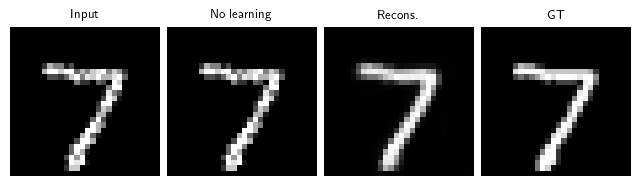

Test PSNR: No learning rec.: 19.356+-1.523 | Model: 23.150+-1.996. 


(23.150262069702148,
 1.9961603806415074,
 19.355849266052246,
 1.5233685706910973)

In [8]:
trainer.plot_images = True
model.MC_samples = 50
trainer.test(test_dataloader)

Since this is a denoising example, above, we have set `eval_split_output` to True (see :class:`deepinv.loss.SplittingLoss` for details). Alternatively, we get worse results when we set `eval_split_output` to False:

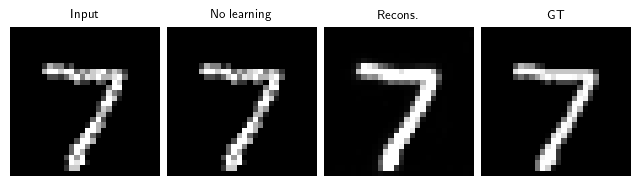

Test PSNR: No learning rec.: 19.356+-1.523 | Model: 14.441+-1.520. 


(14.44115686416626, 1.5199918435073472, 19.355849266052246, 1.5233685706910973)

In [9]:
model.eval_split_output = False
trainer.test(test_dataloader)

Furthermore, we can disable measurement splitting at evaluation altogether by setting `eval_split_input` to False (this is done in [SSDU](https://pubmed.ncbi.nlm.nih.gov/32614100/)):

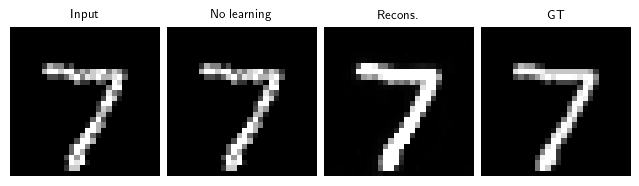

Test PSNR: No learning rec.: 19.356+-1.523 | Model: 9.650+-1.670. 


(9.650477170944214, 1.6700495788637173, 19.355849266052246, 1.5233685706910973)

In [10]:
model.eval_split_input = False
trainer.test(test_dataloader)